In [1]:
%matplotlib inline
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from sympy import *
from ztfquery import lightcurve, query, metasearch
import scipy.stats as st
from scipy.stats import ks_2samp

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### Defining Functions

In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
   
    """Function converts from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    alert_mag : float
        Difference magnitude of alert.
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
        

    Returns
    -------
    app_mag
        Apparent magnitude as type ``float``.
    
    """
    if sign =='t': 
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag)),10))
    else:
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)),10)) 
    
    return float(app_mag)

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err):
    
    """Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    
    alert_mag : float
        Difference magnitude of alert.
    
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
    
    ref_err : float
        1-sigma uncertainty in reference magnitude.
   
    alert_err : float
        1-sigma uncertainty in alert magnitude.
        

    Returns
    -------
    app_err
        Apparent magnitude error as type ``float``.
    
    """
    
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log((10**((-.4)*r)) + (10**((-.4)*a)),10))
    else:
        f = ((-2.5)*log((10**((-.4)*r)) - (10**((-.4)*a)),10)) 
    
    
    # f = diff_to_app_mag(ref_mag, alert_mag, sign)
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

### Query for Disappearing Stars

In [4]:
jdnow = str(Time.now().jd)
days = str(10) # number of days 

selected = '*'


tables = 'objects,sherlock_classifications'


conditions = """
objects.objectId=sherlock_classifications.objectId
AND (objects.sgscore1 > 0.9)
AND (sherlock_classifications.classification != "SN")
AND (sherlock_classifications.classification != "NT")
AND (sherlock_classifications.classification != "AGN")
AND (objects.ncand >= 10)
AND (sherlock_classifications.catalogue_table_name LIKE "%gaia%")
AND (objects.objectId LIKE "ZTF24%")
AND sherlock_classifications.separationArcsec < 0.5
AND ((objects.sgmag1 < 16)
   OR (objects.srmag1 < 16))
AND ISNULL(objects.ncandgp)
AND ("""+jdnow+"""- objects.jdmax) < """+days+"""

"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

try:
    v4 = L.query(selected, tables, conditions)
except LasairError as e:
    print(e)
    
print('Query returned ' + str(len(v4)) + ' candidates in the past '+ days + ' days')

Query returned 42 candidates in the past 10 days


### Plotting Light Curves from Alert Packet and ZTF archive 

/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_6201/393106692.py:103: RuntimeWarning: divide by zero encountered in divide
  chisq_r = np.sum((((rhist - np.median(rhist)) / rhisterr)**2 ) / float(len(rhist)))
/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_6201/393106692.py:103: RuntimeWarning: invalid value encountered in divide
  chisq_r = np.sum((((rhist - np.median(rhist)) / rhisterr)**2 ) / float(len(rhist)))
/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_6201/393106692.py:104: RuntimeWarning: divide by zero encountered in divide
  chisq_r_5to95 = np.sum((((r_5to95 - np.median(r_5to95)) / rerr_5to95)**2 ) / float(len(r_5to95)))
/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_6201/393106692.py:104: RuntimeWarning: invalid value encountered in divide
  chisq_r_5to95 = np.sum((((r_5to95 - np.median(r_5to95)) / rerr_5to95)**2 ) / float(len(r_5to95)))


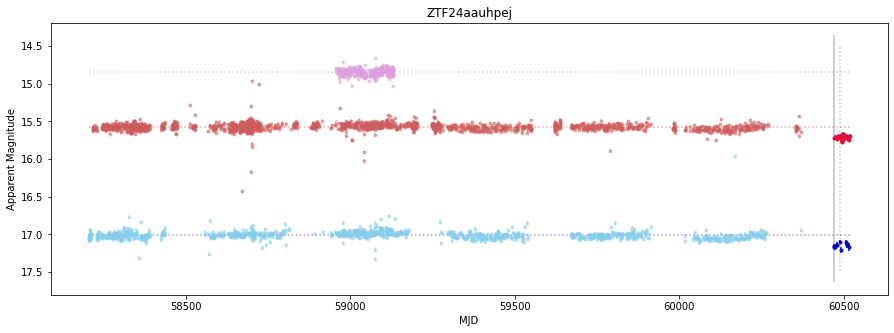

ZTF24aauhpej g-band KS result: KstestResult(statistic=0.9886064855390009, pvalue=4.440892098500626e-16)
ZTF24aauhpej r-band KS result: KstestResult(statistic=0.9910913140311804, pvalue=1.6653345369377348e-15)

ZTF24aauhpej g-band Chi Square statistic: 5.942266076813613
ZTF24aauhpej g-band 5th - 95th percentile Chi Square statistic: 1.5685132535660333
ZTF24aauhpej r-band Chi Square statistic: 7.887514599262101
ZTF24aauhpej r-band 5th - 95th percentile Chi Square statistic: 3.0290768622810025

ZTF24aauhpej has 501 alert packet data points
ZTF24aauhpej has 3708 historic data points



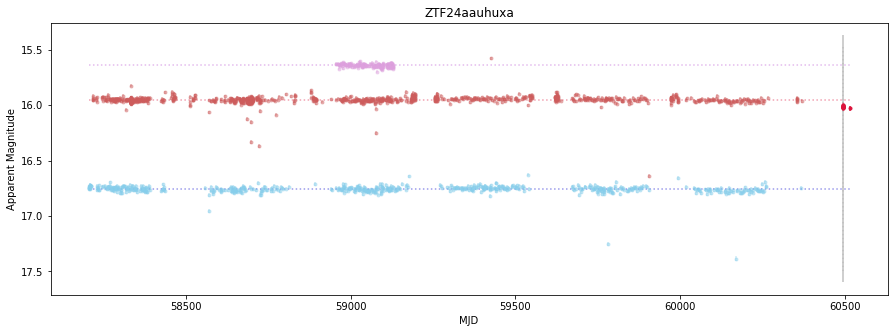

ZTF24aauhuxa r-band KS result: KstestResult(statistic=0.986351228389445, pvalue=1.1408967996413238e-24)

ZTF24aauhuxa r-band Chi Square statistic: 5.334585152351672
ZTF24aauhuxa r-band 5th - 95th percentile Chi Square statistic: 0.7671154328213614

ZTF24aauhuxa has 13 alert packet data points
ZTF24aauhuxa has 1849 historic data points



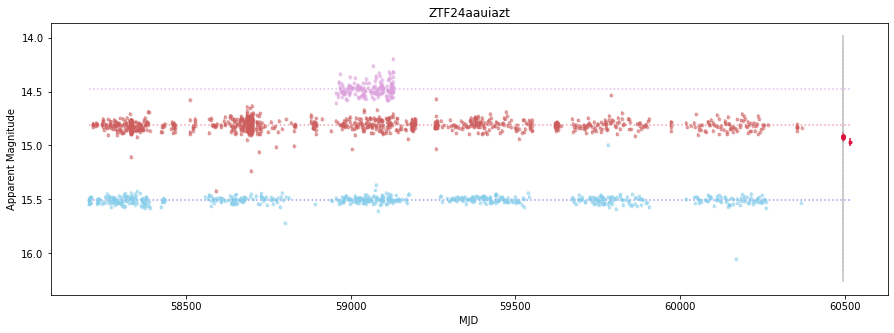

ZTF24aauiazt r-band KS result: KstestResult(statistic=0.9893711248892826, pvalue=0.0)

ZTF24aauiazt r-band Chi Square statistic: 9.564346473487124
ZTF24aauiazt r-band 5th - 95th percentile Chi Square statistic: 3.9659050006710173

ZTF24aauiazt has 13 alert packet data points
ZTF24aauiazt has 1892 historic data points



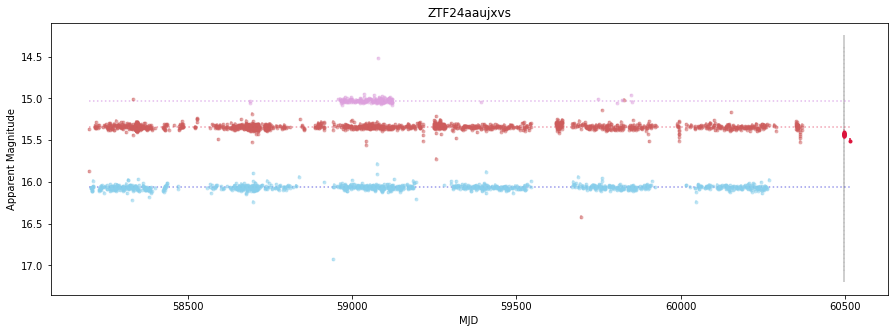

ZTF24aaujxvs r-band KS result: KstestResult(statistic=0.9864068871771635, pvalue=1.4706011372169932e-26)

ZTF24aaujxvs r-band Chi Square statistic: 5.546358857991253
ZTF24aaujxvs r-band 5th - 95th percentile Chi Square statistic: 1.29833704372567

ZTF24aaujxvs has 14 alert packet data points
ZTF24aaujxvs has 3521 historic data points



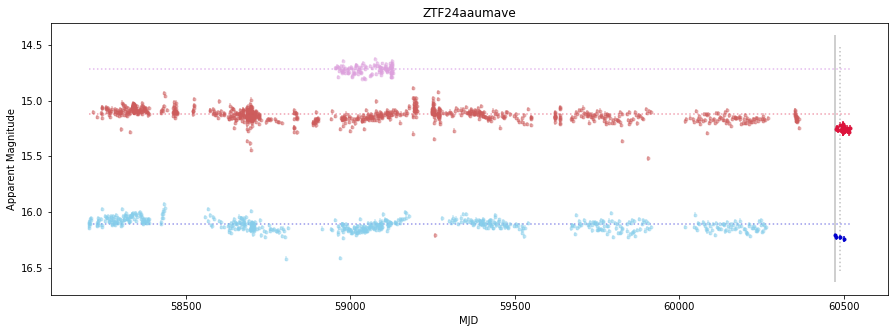

ZTF24aaumave g-band KS result: KstestResult(statistic=0.9808917197452229, pvalue=5.528088575790235e-07)
ZTF24aaumave r-band KS result: KstestResult(statistic=0.9642779112956085, pvalue=3.3306690738754696e-16)

ZTF24aaumave g-band Chi Square statistic: 6.786177779984897
ZTF24aaumave g-band 5th - 95th percentile Chi Square statistic: 3.726111974475238
ZTF24aaumave r-band Chi Square statistic: 9.57961381993792
ZTF24aaumave r-band 5th - 95th percentile Chi Square statistic: 3.8349090521965477

ZTF24aaumave has 142 alert packet data points
ZTF24aaumave has 1938 historic data points



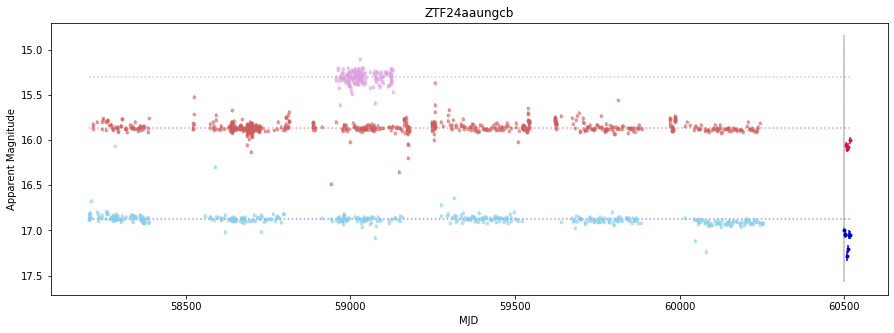

ZTF24aaungcb g-band KS result: KstestResult(statistic=0.9878640776699029, pvalue=3.70314889863721e-12)
ZTF24aaungcb r-band KS result: KstestResult(statistic=0.9895348837209302, pvalue=6.201722413390343e-08)

ZTF24aaungcb g-band Chi Square statistic: 9.509094050659458
ZTF24aaungcb g-band 5th - 95th percentile Chi Square statistic: 1.1166698246817792
ZTF24aaungcb r-band Chi Square statistic: 8.546633007318931
ZTF24aaungcb r-band 5th - 95th percentile Chi Square statistic: 2.1764817004149215

ZTF24aaungcb has 11 alert packet data points
ZTF24aaungcb has 1441 historic data points

36 candidates rejected
6 candidates remain


In [13]:
Dips= L.objects([row['objectId'] for row in v4])
lc = {}
candidates = []
trash = []

for obj in Dips:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')
    
    # Pulling historic ZTF light curve
    ztf = lightcurve.LCQuery.from_position(obj['objectData']['ramean'], obj['objectData']['decmean'], 1)
    
    # Defining arrays of ZTF historic magnitudes for each filter
    ztf_gsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_isamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # same for magnitude errors
    ztf_gerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_ierr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # ...and dates
    ztf_gmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_imjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # calculating 5th - 95th percentile ranges for historic data 
    if len(ztf_gsamp) > 0:
        ghist = ztf_gsamp[(obj['objectData']['discMjd'] - ztf_gmjd) > 100] # restricting data to 100 days before discovery date
        ghisterr = ztf_gerr[(obj['objectData']['discMjd'] - ztf_gmjd) > 100]
        g_p5 = np.percentile(ghist, 5)
        g_p95 = np.percentile(ghist, 95)
        g_5to95 = ghist[(ghist > g_p5) & (ghist < g_p95)]
        gerr_5to95 = ghisterr[(ghist > g_p5) & (ghist < g_p95)]
    
    if len(ztf_rsamp) > 0:
        rhist = ztf_rsamp[(obj['objectData']['discMjd'] - ztf_rmjd) > 100] # restricting data to 100 days before discovery date
        rhisterr = ztf_rerr[(obj['objectData']['discMjd'] - ztf_rmjd) > 100]
        r_p5 = np.percentile(rhist, 5)
        r_p95 = np.percentile(rhist, 95)
        r_5to95 = rhist[(rhist > r_p5) & (rhist < r_p95)]
        rerr_5to95 = rhisterr[(rhist > r_p5) & (rhist < r_p95)]
    
    if len(ztf_isamp) > 0:
        ihist = ztf_isamp[(obj['objectData']['discMjd'] - ztf_imjd) > 100] # restricting data to 100 days before discovery date
        ihisterr = ztf_ierr[(obj['objectData']['discMjd'] - ztf_imjd) > 100]
        i_p5 = np.percentile(ihist, 5)
        i_p95 = np.percentile(ihist, 95)
        i_5to95 = ihist[(ihist > i_p5) & (ihist < i_p95)]
        ierr_5to95 = ihisterr[(ihist > i_p5) & (ihist < i_p95)]
    
    # Creating empty lists for each ZTF filter-band to be filled with apparent magnitudes and errors from alert packet
    gmag = []
    rmag = []
    imag = []
    
    gerr = []
    rerr = []
    ierr = []
    
    gmjd = []
    rmjd = []
    imjd = []
    alertmjd = []
    
    for alert in lc[obj['objectId']]['candidates']:
        if 'isdiffpos' in alert:
            app_mag = diff_to_app_mag(alert['magnr'], alert['magpsf'], alert['isdiffpos']) # calculating apparent magnitude 
            app_err = app_mag_err_prop(alert['magnr'], alert['magpsf'], alert['isdiffpos'], alert['sigmagnr'], alert['sigmapsf']) # propagating error
            alertmjd.append(alert['mjd'])
            
            # appending magnitudes and errors in each filter to their respective lists
            if alert['fid']== 1:
                gmag.append(app_mag)
                gerr.append(app_err)
                gmjd.append(alert['mjd'])
            if alert['fid']== 2:
                rmag.append(app_mag)
                rerr.append(app_err)
                rmjd.append(alert['mjd'])
            if alert['fid']== 3:
                imag.append(app_mag)
                ierr.append(app_err)
                imjd.append(alert['mjd'])
    
    
    # Converting lists of alert packet magnitudes to arrays 
    alert_gsamp = np.array(gmag)
    alert_rsamp = np.array(rmag)
    alert_isamp = np.array(imag)
    
    # Performing K-S test with 95% confidence interval and calculating chi square statistic for each filter
    if len(alert_gsamp) > 0 and len(ghist) > 0:
        KS_g = st.ks_2samp(alert_gsamp, ghist)
        chisq_g = np.sum((((ghist - np.median(ghist)) / ghisterr)**2 ) / float(len(ghist)))
        chisq_g_5to95 = np.sum((((g_5to95 - np.median(g_5to95)) / gerr_5to95)**2 ) / float(len(g_5to95)))
            
    if len(alert_rsamp) > 0 and len(rhist) > 0:  
        KS_r = st.ks_2samp(alert_rsamp, rhist)
        chisq_r = np.sum((((rhist - np.median(rhist)) / rhisterr)**2 ) / float(len(rhist)))
        chisq_r_5to95 = np.sum((((r_5to95 - np.median(r_5to95)) / rerr_5to95)**2 ) / float(len(r_5to95)))

    if len(alert_isamp) > 0 and len(ihist) > 0: 
        KS_i = st.ks_2samp(alert_isamp, ihist)
        chisq_i = np.sum((((ihist - np.median(ihist)) / ihisterr)**2 ) / float(len(ihist)))
        chisq_i_5to95 = np.sum((((i_5to95 - np.median(i_5to95)) / ierr_5to95)**2 ) / float(len(i_5to95)))
           
   
    # Imposing conditions that K-S test p-value is < 0.05 (95% confidence interval) and Chi square statistic is < 50
    g = True
    r = True
    i = True

    # if g true then there are alert samples, at least a hundred historic samples, and they meet the stats
    if len(alert_gsamp) > 0:
        g = False
        if len(ztf_gsamp) >= 100:
            g = (KS_g.pvalue < 0.05) and (np.median(alert_gsamp) > g_p95) and (chisq_g < 10) and (chisq_g_5to95 < 5) 
    
    if len(alert_rsamp) > 0:
        r = False
        if len(ztf_rsamp) >= 100:
            r = (KS_r.pvalue < 0.05) and (np.median(alert_rsamp) > r_p95) and (chisq_r < 10) and (chisq_r_5to95 < 5) 
            
    if len(alert_isamp) > 0:
        i = False
        if len(ztf_isamp) >= 100:
             i = (KS_i.pvalue < 0.05) and (np.median(alert_isamp) > i_p95) and (chisq_i < 10) and (chisq_i_5to95 < 5) 
        
    if g and r and i:
        
        
        
        candidates.append(obj['objectId'])
        
        # Plotting
        plt.figure(figsize = (15, 5))
        plt.subplot(111)

        ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'mediumblue', label = 'g (alert)')
        ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'crimson', label = 'r (alert)')
        ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'mediumorchid', label = 'i (alert)')

        gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'skyblue', alpha = 0.4, label = 'g (historic)')
        rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'indianred', alpha = 0.4, label = 'r (historic)')
        ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'plum', alpha = 0.4, label = 'i (historic)')

        mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='silver', linestyles=':', label='mjd min')  
        disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='silver', label='disc date')
        gmed = plt.hlines(np.median(ztf_gsamp), np.min(ztf.data['mjd']), np.max(alertmjd), color='mediumblue', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        rmed = plt.hlines(np.median(ztf_rsamp), np.min(ztf.data['mjd']), np.max(alertmjd), color='crimson', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        imed = plt.hlines(np.median(ztf_isamp), np.min(ztf.data['mjd']), np.max(alertmjd), color='mediumorchid', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        plt.gca().invert_yaxis()
        plt.ylabel('Apparent Magnitude')
        plt.xlabel('MJD')
        plt.title(obj['objectId'])
        plt.show()

        # Printing K-S test results
        if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
            print(obj['objectId']+' g-band KS result: '+ str(KS_g))

        if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
            print(obj['objectId']+' r-band KS result: '+ str(KS_r))

        if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
            print(obj['objectId']+' i-band KS result: '+ str(KS_i))

        print()

        # Printing Chi Square test results
        if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
            print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
            print(obj['objectId']+' g-band 5th - 95th percentile Chi Square statistic: '+ str(chisq_g_5to95))
            #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

        if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
            print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
            print(obj['objectId']+' r-band 5th - 95th percentile Chi Square statistic: '+ str(chisq_r_5to95))
            #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

        if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
            print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
            print(obj['objectId']+' i-band 5th - 95th percentile Chi Square statistic: '+ str(chisq_i_5to95))
            #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

        print() 
        
        print(obj['objectId']+' has '+ str(len(gmag) + len(rmag) + len(imag))+ ' alert packet data points')
        print(obj['objectId']+' has '+ str(len(ztf.data['mag']))+ ' historic data points')
        
        print ()
        
    else:
        trash.append(obj['objectId'])
        

   
print(str(len(trash)) + ' candidates rejected')
print(str(len(candidates)) + ' candidates remain') 

Current criteria

Lasair query criteria:
- objects.sgscore1 > 0.9 (closer to 1 means the object is more likely to be a star than a galaxy)
- Object is not classified as a supernova, nuclear transient, nor active galactic nucleus by the sherlock classification scheme in Lasair
- Object has at least 10 data points in its alert packet
- Object has been crossmatched with the Gaia catalog
- Object is within 0.5 arcseconds of the best source match from sherlock
- Closest source match object is brighter than 16th magnitude in either g or r band
- Alert magnitudes are all fainter than the reference magnitude
- Alert occurred within the past 10 days
- Object's first alert happened in 2024

Further criteria:
- If object has alert data from a given filter, it must have at least 100 data points in its historic light curve from ZTF for that filter
- Object passes two-sample K-S test with a p-value less than 0.05 in every filter
- Object's historic data has a chi-square statistic less than 10
- Object's historic data that falls within the 5th to 95th percentile range has chi-square statistic less than 5
- Object's median alert magnitude is greater/fainter than the 95th percentile magnitude of the historic data in every filter

Note: K-S and chi square tests are calculated on historic data from over 100 days before the alert epoch

In [6]:
# This could be added plot rejected candidates
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or KS_g.pvalue < 0.05):
#             print('failed g K-S test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or KS_r.pvalue < 0.05):
#             print('failed r K-S test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or KS_i.pvalue < 0.05):
#             print('failed i K-S test')
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or chisq_g < 50):
#             print('failed g Chi square test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or chisq_r < 50):
#             print('failed r Chi square test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or chisq_i < 50):
#             print('failed i Chi square test')     

#         # Plotting
#         plt.figure(figsize = (15, 5))
#         plt.subplot(111)

#         ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
#         ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
#         ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

#         gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
#         rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
#         ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

#         mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lightgray', label='mjd min')  
#         disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
#         plt.gca().invert_yaxis()
#         plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
#         plt.ylabel('Apparent Magnitude')
#         plt.xlabel('mjd')
#         plt.title(obj['objectId'])
#         plt.show()

#         # Printing K-S test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band KS result: '+ str(KS_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band KS result: '+ str(KS_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band KS result: '+ str(KS_i))

#         print()

#         # Printing Chi Square test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
#             #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
#             #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
#             #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

#         print() 